Goal of this notebook: load renewable profiles AND AE data and merge them into one data object

Renewables data:

- solar
    - distributed
    - utility
- wind
    - onshore
    - offshore

variables on timelines:
- cf
- gen


variables on GWLs:
- drought mask

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from climakitae.core.data_interface import (
    get_data)

from renewable_data_load import *

/opt/anaconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# simulation = 'era5'
# scenario = 'reanalysis'

# simulations= ["ec-earth3", "mpi-esm1-2-hr", "miroc6", "taiesm1"]
# scenarios = ["historical", 'ssp370']

In [3]:
# loading renewables and WRF data in timeseries

resource = "pv"
module = "utility"
domain = "d03"
variable = "cf"
frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"

wrf_var = "Precipitation (total)"


# Gen renewables CF data
print(f"Loading {simulation} {scenario} data...")

ren_cf = get_ren_cf_data(
    resource, module, domain, variable, frequency, simulation, scenario
)

# get WRF data
wrf_simulation = sim_name_dict[simulation]
wrf_scenario = scenario_dict[scenario]
wrf_resolution = resolution_dict[domain]
wrfdat = get_data(
    variable=wrf_var,
    downscaling_method="Dynamical",
    resolution=wrf_resolution,
    timescale="daily",
    scenario=wrf_scenario,
)
wrfdat = wrfdat.sel(simulation=wrf_simulation)


# crop the time axis of the WRF data to match the ren data
start_time = ren_cf.time.values[0]
end_time = ren_cf.time.values[-1]
wrfdat = wrfdat.sel(time=slice(start_time, end_time))

combined_ds = xr.merge([wrfdat, ren_cf])
combined_ds = combined_ds.squeeze()

Loading ec-earth3 historical data...


/opt/anaconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:548: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  all_hist = xr.concat(


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



/var/folders/91/kb_yd_5s5v56222sb881rwjc0000gn/T/ipykernel_31921/1368961578.py:41: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  combined_ds = xr.merge([wrfdat, ren_cf])
/var/folders/91/kb_yd_5s5v56222sb881rwjc0000gn/T/ipykernel_31921/1368961578.py:41: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  combined_ds = xr.merge([wrfdat, ren_c

In [4]:
combined_ds

<xarray.Dataset> Size: 10GB
Dimensions:                (time: 12054, x: 223, y: 472)
Coordinates:
  * time                   (time) datetime64[ns] 96kB 1980-12-31 ... 2013-12-31
  * x                      (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                      (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    simulation             <U26 104B 'WRF_EC-Earth3_r1i1p1f1'
    Lambert_Conformal      int32 4B 1
    lakemask               (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    landmask               (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    lat                    (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    lon                    (y, x) float32 421kB dask.array<chunksize=(77, 32), meta=np.ndarray>
    scenario               <U18 72B 'Historical Climate'
Data variables:
    Precipitation (total)  (time, y, x) float32 5GB dask.array<chunksize=(1651, 77, 32), meta=np.ndarray>
    cf                     (y, x, time) float32 5GB dask.array<chunksize=(77, 32, 9143), meta=np.ndarray>
Attributes:
    variable_id:           prec
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 mm
    data_type:             Gridded
    resolution:            3 km
    frequency:             daily
    location_subset:       ['entire domain']
    approach:              Time
    downscaling_method:    Dynamical
    institution:           UCLA
    grid_mapping:          Lambert_Conformal

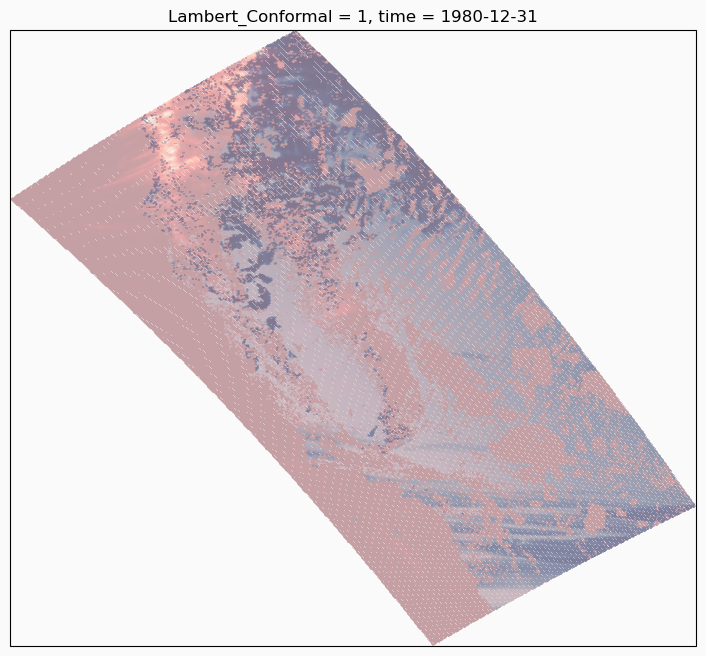

In [5]:
fig = plt.figure(figsize=(10, 8), facecolor="#FAFAFA")  # open matplotlib figure

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor("#FAFAFA")

im = wrfdat.isel(time=0).plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    ax=ax,
    zorder=3,
    alpha=0.2,
    add_colorbar=False,
    cmap="Reds_r",
)

im = ren_cf.isel(time=0).plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    ax=ax,
    zorder=3,
    alpha=0.2,
    add_colorbar=False,
    cmap="Blues_r",
)

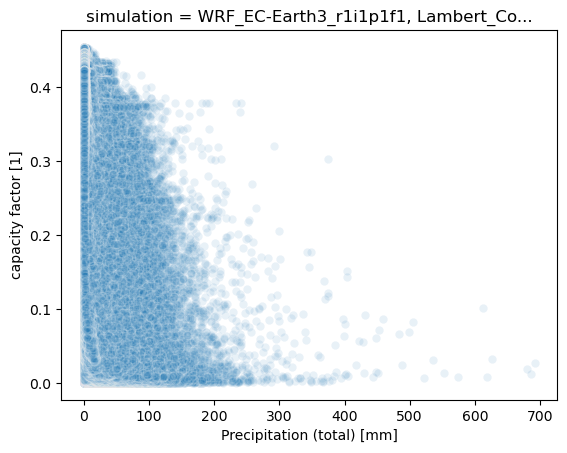

In [ ]:
combined_ds.isel(time=slice(0, 1000)).plot.scatter(
    x="Precipitation (total)", y="cf", alpha=0.1
)

In [ ]:
## WIP - loading drought data on GWLs
resource = "pv"
module = "utility"
domain = "d02"

frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"

gwl = "plus08c"

wrf_var = "Precipitation (total)"


variable = "drought_mask"

# Gen renewables CF data
print(f"Loading {simulation} {scenario} data...")

ds = get_ren_drought_data(
    resource, module, domain, variable, frequency, simulation, gwl
)
ren_cf = ds["drought_mask"]
ren_cf = ren_cf.isel(
    x=slice(10, -10), y=slice(10, -10)
)  # trim the edges to match the WRF AE domain (check this for d03)

# get WRF data
wrf_simulation = sim_gwl_name_dict[simulation]
wrf_scenario = scenario_dict[scenario]
wrf_resolution = resolution_dict[domain]

wrfdat = get_data(
    variable=wrf_var,
    downscaling_method="Dynamical",
    resolution=wrf_resolution,
    timescale="daily",
    scenario=wrf_scenario,
    approach="Warming Level",
    warming_level=gwl_name_dict[gwl],
)
wrfdat = wrfdat.sel(simulation=wrf_simulation)

# crop the time axis of the WRF data to match the ren data
start_time = ren_cf.time.values[0]
end_time = ren_cf.time.values[-1]
wrfdat = wrfdat.sel(time=slice(start_time, end_time))

combined_ds = xr.merge([wrfdat, ren_cf])
combined_ds = combined_ds.squeeze()

Loading ec-earth3 historical data...


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:548: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  all_hist = xr.concat(
/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/climakitae/core/data_load.py:589: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  one_scenario = xr.concat

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



KeyError: "not all values found in index 'simulation'. Try setting the `method` keyword argument (example: method='nearest')."

In [8]:
## WIP - loading drought data on GWLs
resource = "pv"
module = "utility"
domain = "d02"

frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"

gwl = "plus08c"

wrf_var = "Precipitation (total)"


variable = "drought_count"

# Gen renewables CF data
print(f"Loading {simulation} {scenario} data...")

ds = get_ren_drought_data(
    resource, module, domain, variable, frequency, simulation, gwl
)

Loading ec-earth3 historical data...


GroupNotFoundError: No group found in store 's3://wfclimres/era/resource_drought/pv/pv_utility/ec-earth3/plus08c/day/drought_count/d02' at path ''

In [127]:
wrf_simulation = sim_gwl_name_dict[simulation]

wrfdat = wrfdat.sel(simulation=wrf_simulation)